#  Fitting a Convolutional Autoencoder (CNN-AE) with Pytorch


## Import libraries, including PyTorch
If you are using your own computer, you will need to install Pytorch. Setup guidance is here: https://pytorch.org/get-started/locally/)

In [1]:
import pandas as pd
from tqdm import trange, tqdm
import torch
torch.set_num_threads(2)
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F                # contains activation functions, sampling layers etc
import torchvision
from torchvision import transforms
from torchvision.utils import make_grid    
from torch.utils.data import DataLoader        # to load data into batches (for SGD)
import torch.optim as optim                    # For optimization routines such as SGD, ADAM, ADAGRAD, etc
from torch.utils.data import DataLoader,random_split

### Load in the MNIST digits data

Like yesterday, we use the MNIST digits dataset. We split the training dataset into training and validation sets. 

In [2]:
data_dir = 'dataset'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

train_transform = transforms.Compose([
transforms.ToTensor(),
])

test_transform = transforms.Compose([
transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m = len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size = 256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

## View basic data set information
Now that the dataset has been imported, you can view information about the train/test set using print(train_data) if you wish. You will see that there are 60000 training examples and 10000 test examples

In [3]:
print(train_dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: dataset
    Split: Train


### Below we create the encoder and decoder objects

Can you draw this neural network as a block diagram? 

In [4]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x
    
    
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, 
            stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, 
            padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, 
            padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

### Below we define the loss function, learning rate and latent space dimension


In [5]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks and set the latent dimension 
d = 4

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=d,fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=d,fc2_input_dim=128)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cpu


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

### Below we define how the training is done and collect the training loss from each batch of data

In [6]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

### We also compute the loss over validation data to determine when is a good time to stop training

In [7]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

### Below is a function to plot the images recontructed by the autoencoder

In [8]:
def plot_ae_outputs(encoder,decoder,n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()   

### Below is some code to train for a number of epochs (an epoch is one complete pass through the data) 

If you want to use pre-trained models you can comment out this block and uncomment the block to load in models

	 partial train loss (single batch): 0.253315
	 partial train loss (single batch): 0.245793
	 partial train loss (single batch): 0.241166
	 partial train loss (single batch): 0.235455
	 partial train loss (single batch): 0.231942
	 partial train loss (single batch): 0.227938
	 partial train loss (single batch): 0.225441
	 partial train loss (single batch): 0.222765
	 partial train loss (single batch): 0.220347
	 partial train loss (single batch): 0.217582
	 partial train loss (single batch): 0.215511
	 partial train loss (single batch): 0.213436
	 partial train loss (single batch): 0.210830
	 partial train loss (single batch): 0.208848
	 partial train loss (single batch): 0.206869
	 partial train loss (single batch): 0.204481
	 partial train loss (single batch): 0.202863
	 partial train loss (single batch): 0.200939
	 partial train loss (single batch): 0.199029
	 partial train loss (single batch): 0.196947
	 partial train loss (single batch): 0.195493
	 partial train loss (single batch

	 partial train loss (single batch): 0.067078
	 partial train loss (single batch): 0.067999
	 partial train loss (single batch): 0.067184
	 partial train loss (single batch): 0.066956
	 partial train loss (single batch): 0.065736
	 partial train loss (single batch): 0.065403
	 partial train loss (single batch): 0.066070

 EPOCH 1/10 	 train loss 0.12237265706062317 	 val loss 0.06565294414758682


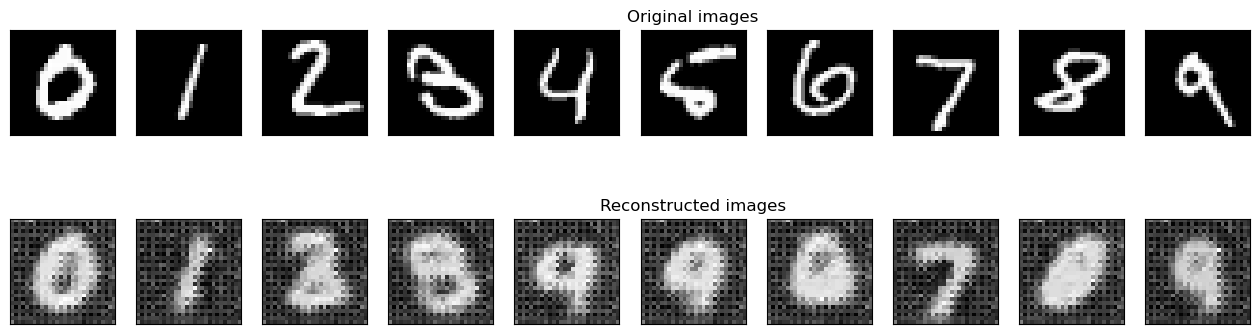

	 partial train loss (single batch): 0.065985
	 partial train loss (single batch): 0.065788
	 partial train loss (single batch): 0.063488
	 partial train loss (single batch): 0.065861
	 partial train loss (single batch): 0.064586
	 partial train loss (single batch): 0.064670
	 partial train loss (single batch): 0.063906
	 partial train loss (single batch): 0.062620
	 partial train loss (single batch): 0.063350
	 partial train loss (single batch): 0.063236
	 partial train loss (single batch): 0.063188
	 partial train loss (single batch): 0.063529
	 partial train loss (single batch): 0.063612
	 partial train loss (single batch): 0.062852
	 partial train loss (single batch): 0.062740
	 partial train loss (single batch): 0.063029
	 partial train loss (single batch): 0.061872
	 partial train loss (single batch): 0.061087
	 partial train loss (single batch): 0.061980
	 partial train loss (single batch): 0.061019
	 partial train loss (single batch): 0.059968
	 partial train loss (single batch

	 partial train loss (single batch): 0.045812
	 partial train loss (single batch): 0.044994
	 partial train loss (single batch): 0.045352
	 partial train loss (single batch): 0.047020
	 partial train loss (single batch): 0.046143
	 partial train loss (single batch): 0.046414
	 partial train loss (single batch): 0.044713
	 partial train loss (single batch): 0.044687
	 partial train loss (single batch): 0.045735

 EPOCH 2/10 	 train loss 0.05307159200310707 	 val loss 0.045691557228565216


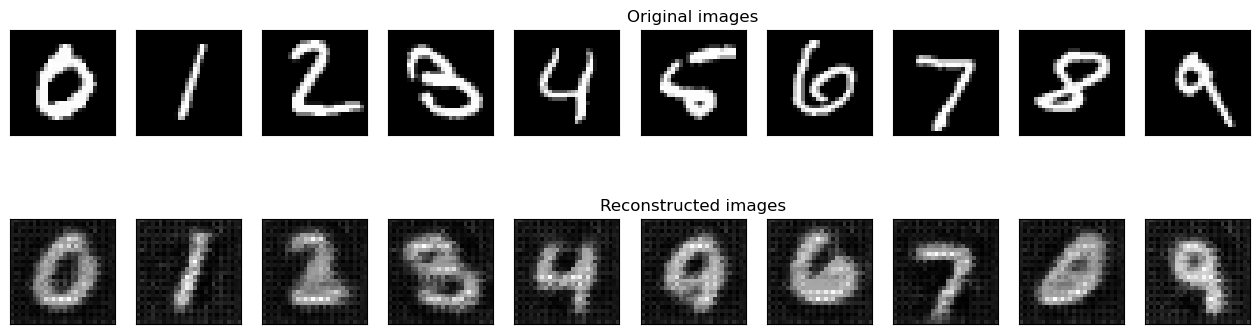

	 partial train loss (single batch): 0.045782
	 partial train loss (single batch): 0.045700
	 partial train loss (single batch): 0.043090
	 partial train loss (single batch): 0.046119
	 partial train loss (single batch): 0.045207
	 partial train loss (single batch): 0.045462
	 partial train loss (single batch): 0.044145
	 partial train loss (single batch): 0.043329
	 partial train loss (single batch): 0.044145
	 partial train loss (single batch): 0.044110
	 partial train loss (single batch): 0.044037
	 partial train loss (single batch): 0.045197
	 partial train loss (single batch): 0.045417
	 partial train loss (single batch): 0.044721
	 partial train loss (single batch): 0.044502
	 partial train loss (single batch): 0.045069
	 partial train loss (single batch): 0.044208
	 partial train loss (single batch): 0.043567
	 partial train loss (single batch): 0.044560
	 partial train loss (single batch): 0.043568
	 partial train loss (single batch): 0.042278
	 partial train loss (single batch

	 partial train loss (single batch): 0.038119
	 partial train loss (single batch): 0.037485
	 partial train loss (single batch): 0.037781
	 partial train loss (single batch): 0.036107
	 partial train loss (single batch): 0.036074
	 partial train loss (single batch): 0.036695

 EPOCH 3/10 	 train loss 0.0404626727104187 	 val loss 0.03680552914738655


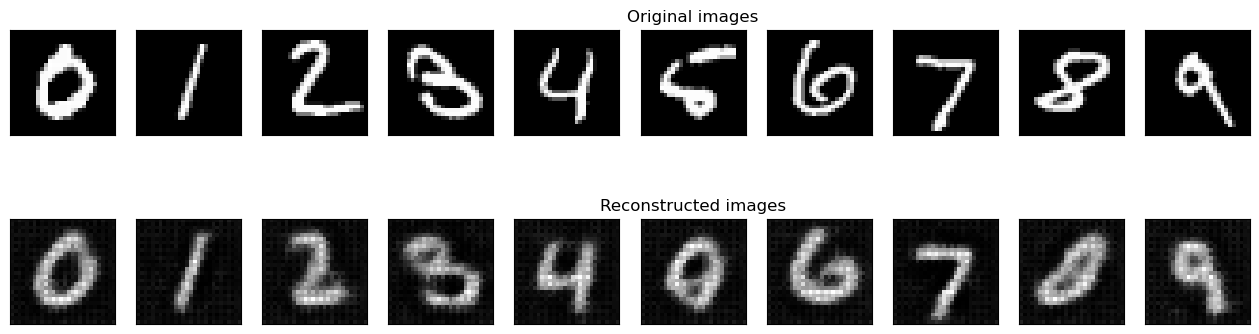

	 partial train loss (single batch): 0.037099
	 partial train loss (single batch): 0.036568
	 partial train loss (single batch): 0.034159
	 partial train loss (single batch): 0.037489
	 partial train loss (single batch): 0.036600
	 partial train loss (single batch): 0.037329
	 partial train loss (single batch): 0.035360
	 partial train loss (single batch): 0.035050
	 partial train loss (single batch): 0.035497
	 partial train loss (single batch): 0.035723
	 partial train loss (single batch): 0.035401
	 partial train loss (single batch): 0.036752
	 partial train loss (single batch): 0.037286
	 partial train loss (single batch): 0.036428
	 partial train loss (single batch): 0.036378
	 partial train loss (single batch): 0.036727
	 partial train loss (single batch): 0.035991
	 partial train loss (single batch): 0.035623
	 partial train loss (single batch): 0.036562
	 partial train loss (single batch): 0.035593
	 partial train loss (single batch): 0.034279
	 partial train loss (single batch

	 partial train loss (single batch): 0.031695
	 partial train loss (single batch): 0.032143
	 partial train loss (single batch): 0.034302
	 partial train loss (single batch): 0.033639
	 partial train loss (single batch): 0.033909
	 partial train loss (single batch): 0.032508
	 partial train loss (single batch): 0.032476
	 partial train loss (single batch): 0.032577


In [ ]:
num_epochs = 10
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   train_loss = train_epoch(encoder,decoder,device,
   train_loader,loss_fn,optim)
   val_loss = test_epoch(encoder,decoder,device,test_loader,loss_fn)
   print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   diz_loss['train_loss'].append(train_loss)
   diz_loss['val_loss'].append(val_loss)
   plot_ae_outputs(encoder,decoder,n=10)

In [ ]:
### Code below to save the models so that you can use them without retraining in the future

In [ ]:
# torch.save(encoder.state_dict(), './saved_models/cnn_ae_encoder')
# torch.save(decoder.state_dict(), './saved_models/cnn_ae_decoder')

### Below is code to load in the trained models in case you don't want to rerun

The code has been commented out since we've trained the models above

In [ ]:
# encoder = Encoder(encoded_space_dim=d,fc2_input_dim=128)
# decoder = Decoder(encoded_space_dim=d,fc2_input_dim=128)
# encoder.load_state_dict(torch.load('./saved_models/cnn_ae_encoder'))
# decoder.load_state_dict(torch.load('./saved_models/cnn_ae_decoder'))
# encoder.to(device)
# decoder.to(device)
# encoder.eval()
# decoder.eval()

# plot_ae_outputs(encoder,decoder,n=10)

### Below is the test error

In [ ]:
test_epoch(encoder,decoder,device,test_loader,loss_fn).item()

### Below we plot the training and validation loss

In [ ]:
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.show()

### Below we draw some images from random points in the latent space. 

Since the autoencoder latent space can be quite irregular and therefore some of the generated samples don't look so good. 

In [ ]:
def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

encoder.eval()
decoder.eval()

with torch.no_grad():
    # calculate mean and std of latent code, generated takining in test images as inputs 
    testiter = iter(test_loader)
    images, labels = next(testiter)
    images = images.to(device)
    latent = encoder(images)
    latent = latent.cpu()

    mean = latent.mean(dim=0)
    print(f"means: {mean}")
    std = (latent - mean).pow(2).mean(dim=0).sqrt()
    print(f"standard deviations: {std}")

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, d)*std + mean

    # reconstruct images from the random latent vectors
    latent = latent.to(device)
    img_recon = decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(img_recon[:100],10,5))
    plt.show()

### Below we look at where the different digits lie in the latent space

Note that the model is unsupervised and the labels were not used for training, but it can be observed that there is some reasonable clustering of the digits in the latent space. 

We have now put the encoded test data in a pandas dataframe so you can use the methods from the unsupervised learning labs to cluster and visualise the latent space

In [ ]:
test_subset_size = 1000 # We just take 1000 samples from the test data to keep computation time down
encoded_samples = []
for i in tqdm(range(1,test_subset_size+1)):
    sample_idx = torch.randint(len(test_dataset), size=(1,)).item()
    sample = test_dataset[sample_idx]
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
    
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

import plotly.express as px

px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples.label.astype(str), opacity=0.7)


### Below we put the labels in the index of the dataframe

Now the encoded test data is ready to be clustered or visualised as you wish. The format of the data is the same as you used in the PCA and clustering labs

In [ ]:
encoded_data = encoded_samples.set_index('label')
labels = encoded_data.index.astype(str)
encoded_data